In [6]:
''' compare GFS against alongtrack SD wind - convert wind(SD 3.5m) to wind(SD 10m) '''
''' use coare3.6 to convert wind at 10m - need: uwnd, vwnd, air temp, rh, air pressure, '''
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
from scipy import stats
# from metpy import calc
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from convert_dir import vector_dir_to_from
from values_to_colors import truncate_colormap
from convert_time import datetime_to_yearday
from coare36vn_zrf_et import coare36vn_zrf_et
from windstr import wind_adj2height_PL

In [4]:
''' SD data info '''
year = '2023'
platfs_num = ['1031','1036','1040','1041','1042','1045','1057','1064','1065','1068','1069','1083']#['1036','1041','1069']
path_SD = os.path.expanduser('~/Documents/projects/sd-ni-wp/SD_windstress/compare_SD_model/data_timeseries_match_SD_GFS/')
filenames_SD_all = np.sort( os.listdir(path_SD) )
filenames_SD = np.array([])
for file in filenames_SD_all:
    if ('u10m' in file) & ('.txt' in file) & (year in file) & (file[-12:-8] in platfs_num):
        filenames_SD = np.append(filenames_SD, file)
print(len(filenames_SD), filenames_SD)

12 ['timeseries_wnd_u10m_match_2023-SD1031_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1036_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1040_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1041_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1042_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1045_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1057_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1064_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1065_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1068_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1069_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1083_GFS.txt']


In [10]:
''' load all SD data in filenames_SD and plot stats '''
if 'data_all' in locals():
    del data_all
for i, platf_num in enumerate( platfs_num ):
    temp = np.genfromtxt( path_SD+'timeseries_wnd_u10m_match_'+year+'-SD'+platf_num+'_GFS.txt', dtype=float,\
                         delimiter=' ',skip_header=1)
    temp = np.column_stack( (i*np.ones( (temp.shape[0],) ), temp) )
    ''' append to data_all '''
    if 'data_all' not in locals():
        data_all = temp
    else:
        data_all = np.vstack( (data_all, temp) )
    print(platf_num, data_all.shape)

1031 (1963, 12)
1036 (3997, 12)
1040 (5079, 12)
1041 (6495, 12)
1042 (7221, 12)
1045 (9263, 12)
1057 (10718, 12)
1064 (11245, 12)
1065 (12252, 12)
1068 (13907, 12)
1069 (16114, 12)
1083 (18062, 12)


In [12]:
''' name data '''
# print(data_all[0,:])
uSD = data_all[:,6]
vSD = data_all[:,8]
uSD10m_coare = data_all[:,10]
vSD10m_coare = data_all[:,11]
uSD10m_PL = wind_adj2height_PL( uSD, 3.5, 10 )
vSD10m_PL = wind_adj2height_PL( vSD, 3.5, 10 )
uGFS10m = data_all[:,7]
vGFS10m = data_all[:,9]

[ 0.00000000e+00  1.69087680e+09 -6.55399360e+01  2.30218656e+01
  5.27819321e-02 -2.41893134e-03 -6.44000000e+00 -6.33711433e+00
  7.30000000e-01  4.76592571e-01 -6.55084727e+00  1.40459959e+00]


Shape of 1031 u : (1963, 12)
Shape of 1036 u : (2034, 12)
Shape of 1040 u : (1082, 12)
Shape of 1041 u : (1416, 12)
Shape of 1042 u : (726, 12)
Shape of 1045 u : (2042, 12)
Shape of 1057 u : (1455, 12)
Shape of 1064 u : (527, 12)
Shape of 1065 u : (1007, 12)
Shape of 1068 u : (1655, 12)
Shape of 1069 u : (2207, 12)
Shape of 1083 u : (1948, 12)
Shape of 1031 v : (1963, 12)
Shape of 1036 v : (2034, 12)
Shape of 1040 v : (1082, 12)
Shape of 1041 v : (1416, 12)
Shape of 1042 v : (726, 12)
Shape of 1045 v : (2042, 12)
Shape of 1057 v : (1455, 12)
Shape of 1064 v : (527, 12)
Shape of 1065 v : (1007, 12)
Shape of 1068 v : (1655, 12)
Shape of 1069 v : (2207, 12)
Shape of 1083 v : (1948, 12)


<Figure size 432x288 with 0 Axes>

<Figure size 1440x1044 with 0 Axes>

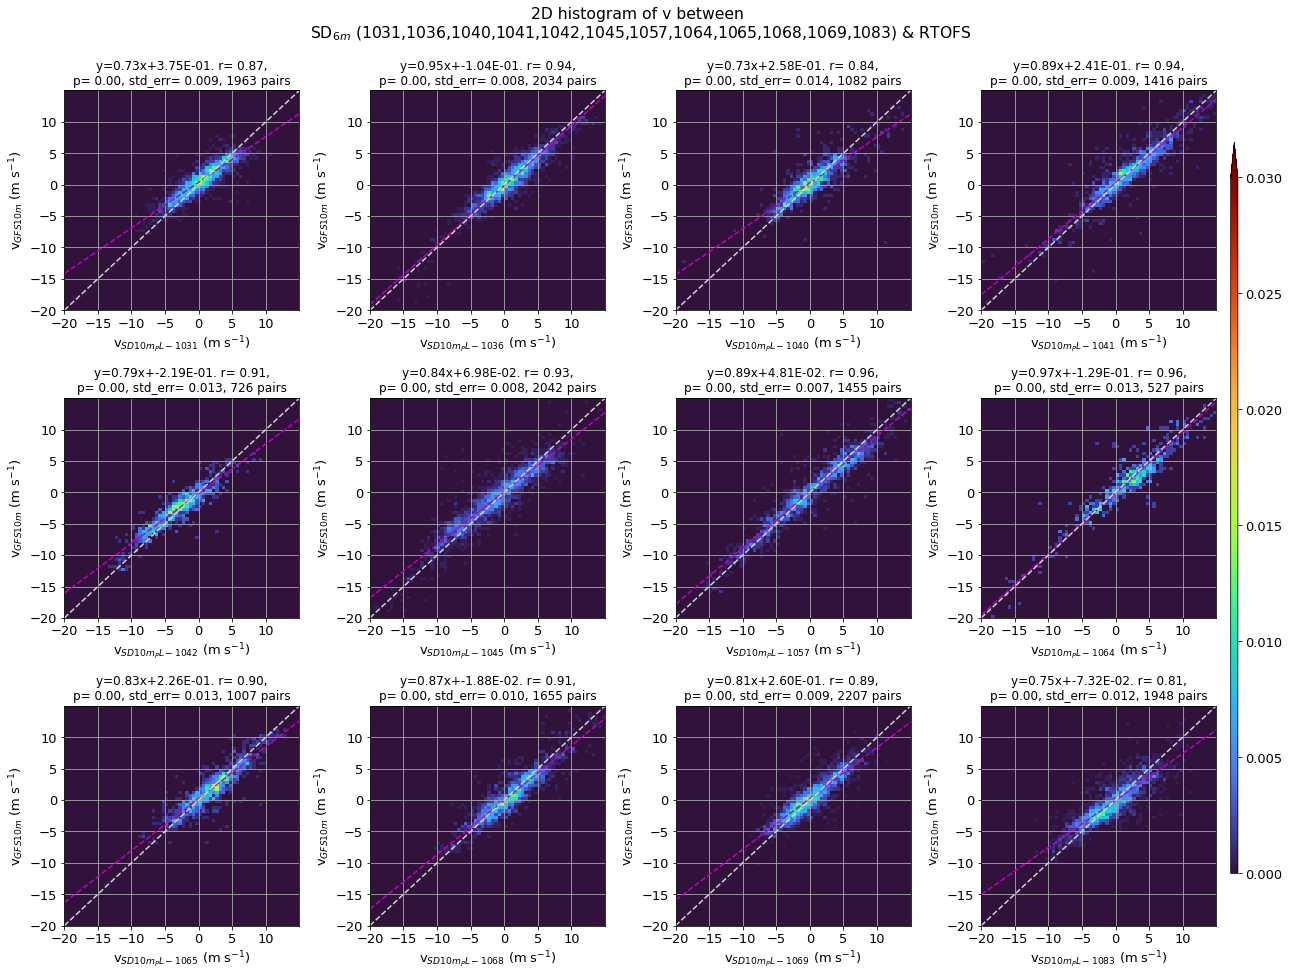

In [90]:
''' plot 2D-histogram of uwnd & vwnd - individual SD '''
nrow = 3; ncol = 4
bins = np.arange(-20,15.5,0.5)
xlim = [-20,15]
x0 = np.arange(bins[0],bins[-1]+0.1,0.1)
histlim = [0,0.03]
vars_to_plot = ['u','v']
axes_name_str = ['SD10m_PL','GFS10m']
# axes_name_str = ['SD10m_coare','GFS10m']
# axes_name_str = ['SD10m_coare','SD10m_PL']
''' plot '''
for v, var_to_plot in enumerate( vars_to_plot ):
    plt.clf()
    plt.rcParams.update({'font.size': 13})
    fig, ax = plt.subplots(nrows=nrow,ncols=ncol)
    fig.set_size_inches(20, 14.5)
    for i, platf_num in enumerate(platfs_num):
        irows = np.where( data_all[:,0] == i )[0]
        print('Shape of',platf_num,var_to_plot,':',data_all[irows,:].shape)
        ''' plot '''
        plt.subplot(nrow,ncol,i+1)
        x = eval(var_to_plot+axes_name_str[0]+'[irows]')
        y = eval(var_to_plot+axes_name_str[1]+'[irows]')
        slope, intercept, r, p, std_err = stats.linregress(x,y)
        h, xedges,yedges = np.histogram2d(x, y, bins=bins,density=True)
        cs = plt.pcolormesh(xedges, yedges, h.transpose()/h.sum(), cmap='turbo',vmin=histlim[0],vmax=histlim[1])
        plt.plot( x0, x0*slope+intercept, 'm--')
        plt.xlabel(var_to_plot+'$_{'+axes_name_str[0]+'-'+platf_num+'}$ (m s$^{-1}$)')
        plt.ylabel(var_to_plot+'$_{'+axes_name_str[1]+'}$ (m s$^{-1}$)')
        plt.title('y={:.2f}x+{:.2E}. r= {:.2f},\np= {:.2f}, std_err= {:.3f}, {:.0f} pairs'\
                  .format(slope,intercept,r,p,std_err,len(irows)), fontsize=12)
    ''' add colorbar '''
    axf = fig.add_axes([0.91,0.15,0.005,0.7])
    axf = plt.colorbar(cs,orientation='vertical',cax=axf,extend='max')
    # axf.set_label('',fontsize=14)
    ''' settings '''
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        # plt.axis('equal')
        plt.plot(xlim,xlim,'--',color='lightgray')
        plt.grid()
        plt.xticks(np.arange(xlim[0],xlim[1],5))
        plt.yticks(np.arange(xlim[0],xlim[1],5))
        plt.xlim(xlim)
        plt.ylim(xlim)
    plt.suptitle('2D histogram of '+var_to_plot+' between \nSD$_{6m}$ ('+','.join(platfs_num)+') & RTOFS')
    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.4)
    ''' save figure '''
    # break
    plt.savefig('2Dhist_'+var_to_plot+'_'+'-vs-'.join(axes_name_str)+'_('+year+':'+'-'.join(platfs_num)+').png',dpi=400,bbox_inches='tight')

/Users/chi/opt/anaconda3/envs/pycode/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


<Figure size 432x288 with 0 Axes>

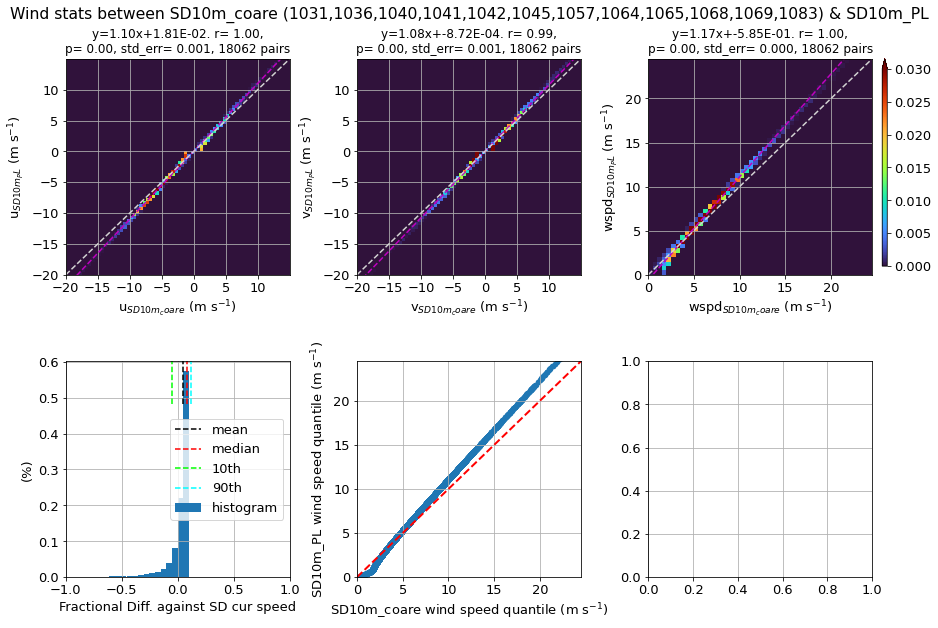

In [103]:
''' plot stats of wind components and wind speeds '''
nrow = 2; ncol = 3
bins = np.arange(-20,15.5,0.5)
bins_spd = np.arange(0,25,0.5)
xlim = [bins[0],bins[-1]]
xlim_spd = [bins_spd[0],bins_spd[-1]]
x0 = np.arange(bins[0],bins[-1]+0.1,0.1)
x0_spd = np.arange(bins_spd[0],bins_spd[-1]+0.1,0.1)
histlim = [0,0.03]
vars_to_plot = ['u','v']
# axes_name_str = ['SD10m_PL','GFS10m']
# axes_name_str = ['SD10m_coare','GFS10m']
axes_name_str = ['SD10m_coare','SD10m_PL']
''' plot 2D-histogram of u & v - all SDs specified '''
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(nrows=nrow,ncols=ncol)
fig.set_size_inches(14, 9)
for v, var_to_plot in enumerate( vars_to_plot ):
    ''' plot '''
    plt.subplot(nrow,ncol,v+1)
    x = eval(var_to_plot+axes_name_str[0])
    y = eval(var_to_plot+axes_name_str[1])
    slope, intercept, r, p, std_err = stats.linregress(x,y)
    h, xedges,yedges = np.histogram2d(x, y, bins=bins,density=True)
    cs = plt.pcolormesh(xedges, yedges, h.transpose()/h.sum(), cmap='turbo',vmin=histlim[0],vmax=histlim[1])
    plt.plot( x0, x0*slope+intercept, 'm--')
    plt.xlabel(var_to_plot+'$_{'+axes_name_str[0]+'}$ (m s$^{-1}$)')
    plt.ylabel(var_to_plot+'$_{'+axes_name_str[1]+'}$ (m s$^{-1}$)')
    plt.title('y={:.2f}x+{:.2E}. r= {:.2f},\np= {:.2f}, std_err= {:.3f}, {:.0f} pairs'\
                .format(slope,intercept,r,p,std_err,data_all.shape[0]), fontsize=12)
''' plot 2D-histogram of wind speed '''
plt.subplot(nrow,ncol,3)
x = np.sqrt( np.square(eval('u'+axes_name_str[0])) + np.square(eval('v'+axes_name_str[0])) )
y = np.sqrt( np.square(eval('u'+axes_name_str[1])) + np.square(eval('v'+axes_name_str[1])) )
slope, intercept, r, p, std_err = stats.linregress(x,y)
h, xedges,yedges = np.histogram2d(x, y, bins=bins_spd,density=True)
cs = plt.pcolormesh(xedges, yedges, h.transpose()/h.sum(), cmap='turbo',vmin=histlim[0],vmax=histlim[1])
plt.plot( x0_spd, x0_spd*slope+intercept, 'm--')
plt.xlabel('wspd$_{'+axes_name_str[0]+'}$ (m s$^{-1}$)')
plt.ylabel('wspd$_{'+axes_name_str[1]+'}$ (m s$^{-1}$)')
plt.title('y={:.2f}x+{:.2E}. r= {:.2f},\np= {:.2f}, std_err= {:.3f}, {:.0f} pairs'\
            .format(slope,intercept,r,p,std_err,data_all.shape[0]), fontsize=12)
''' add colorbar '''
axf = fig.add_axes([0.91,0.58,0.005,0.32])
axf = plt.colorbar(cs,orientation='vertical',cax=axf,extend='max')
''' plot fractional differences against SD current speed and their mean '''
plt.subplot(nrow,ncol,4)
frac_diff = (y-x)/x
hist, xedges = np.histogram(frac_diff, bins=np.linspace(-1.5,1.5,60),density=True)
plt.bar(xedges[:-1], hist/hist.sum(), width=0.05, align='center',label='histogram')
ylim_gca = plt.gca().get_ylim()
ylim_marker = [ylim_gca[0]+0.8*np.diff(ylim_gca), ylim_gca[1]]
plt.plot(np.mean(frac_diff)*np.array([1,1]),ylim_marker,'k--',label='mean')
plt.plot(np.median(frac_diff)*np.array([1,1]),ylim_marker,'r--',label='median')
plt.plot(np.percentile(frac_diff,10)*np.array([1,1]),ylim_marker,'--',color='lime',label='10th')
plt.plot(np.percentile(frac_diff,90)*np.array([1,1]),ylim_marker,'--',color='cyan',label='90th')
plt.legend()
plt.ylim(ylim_gca)
plt.ylabel('(%)')
plt.xlabel('Fractional Diff. against SD cur speed')
''' plot quantile-quantile plot comparing SD and RTOFS current speed probability distribution 
by their quantiles against each other.
Follow Q-Q plot with 2 datasets 
https://www.yourdatateacher.com/2021/06/21/how-to-use-q-q-plot-for-checking-the-distribution-of-our-data/ '''
plt.subplot(nrow,ncol,5)
plt.scatter(np.sort(x), np.sort(y),s=20)
# plt.plot([min(x),max(x)],[min(y),max(y)],'r--')
plt.plot(xlim_spd,xlim_spd,'r--',lw=2)
plt.xlabel(axes_name_str[0]+' wind speed quantile (m s$^{-1}$)')
plt.ylabel(axes_name_str[1]+' wind speed quantile (m s$^{-1}$)')
''' settings '''
for i in range(nrow*ncol):
    plt.subplot(nrow,ncol,i+1)
    if i < 2:
        plt.plot(xlim,xlim,'--',color='lightgray')
    plt.grid()
    if i < 2:
        plt.xticks(np.arange(xlim[0],xlim[1],5))
        plt.yticks(np.arange(xlim[0],xlim[1],5))
        plt.xlim(xlim)
        plt.ylim(xlim)
    if i == 2:
        plt.plot(xlim_spd,xlim_spd,'--',color='lightgray')
        plt.xticks(np.arange(xlim_spd[0],xlim_spd[1],5))
        plt.yticks(np.arange(xlim_spd[0],xlim_spd[1],5))
        plt.xlim(xlim_spd)
        plt.ylim(xlim_spd)
    if i == 3:
        plt.xticks(np.arange(-2,2.5,0.5))
        plt.xlim([-1,1])
    if i == 4:
        plt.xlim(xlim_spd)
        plt.ylim(xlim_spd)
        plt.xticks(np.arange(xlim_spd[0],xlim_spd[1],5))
        plt.yticks(np.arange(xlim_spd[0],xlim_spd[1],5))
plt.suptitle('Wind stats between '+axes_name_str[0]+' ('+','.join(platfs_num)+') & '+axes_name_str[1])
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.4)
''' save figure '''
plt.savefig('2Dhist_quantile_'+''.join(vars_to_plot)+'_'+'-vs-'.join(axes_name_str)+'_('+year+':'+'-'.join(platfs_num)+').png',dpi=400,bbox_inches='tight')

In [112]:
''' compute other stats between GFS & SD wind speeds '''
# axes_name_str = ['SD10m_PL','GFS10m']
# axes_name_str = ['SD10m_coare','GFS10m']
axes_name_str = ['SD10m_coare','SD10m_PL']
x = np.sqrt( np.square(eval('u'+axes_name_str[0])) + np.square(eval('v'+axes_name_str[0])) )
y = np.sqrt( np.square(eval('u'+axes_name_str[1])) + np.square(eval('v'+axes_name_str[1])) )
''' conditions applied '''
isOK = np.where( x< 10 )[0]
print('This regime account for {:.2f}%'.format(len(isOK)/len(x)*100)+' of '+axes_name_str[0]+' data')
x = x[isOK]
y = y[isOK]
''''''
print('stats between '+' & '.join(axes_name_str))
mag_vect_diff = np.sqrt( np.square(eval('u'+axes_name_str[0])[isOK]-eval('u'+axes_name_str[1])[isOK])+\
                        np.square(eval('v'+axes_name_str[0])[isOK]-eval('v'+axes_name_str[1])[isOK]) )
print('RMSD of magnitude of wind vector difference= {:.2f} m/s'.format( np.sqrt( np.sum(np.square(mag_vect_diff))/len(mag_vect_diff)) ) )
bias = np.sum( y-x )/len(x)
print('bias ('+axes_name_str[1]+' against '+axes_name_str[0]+' wind speed)= {:.2f} m/s'.format(bias))
SDE = np.sqrt( np.sum( np.square(y-x-bias) )/len(x) )
print('SDE (std of errors or residual difference) of wind speed= {:.2f} m/s'.format(SDE))

This regime account for 91.23% of SD10m_coare data
stats between SD10m_coare & SD10m_PL
RMSD of magnitude of wind vector difference= 0.76 m/s
bias (SD10m_PL against SD10m_coare wind speed)= 0.39 m/s
SDE (std of errors or residual difference) of wind speed= 0.45 m/s


<Figure size 432x288 with 0 Axes>

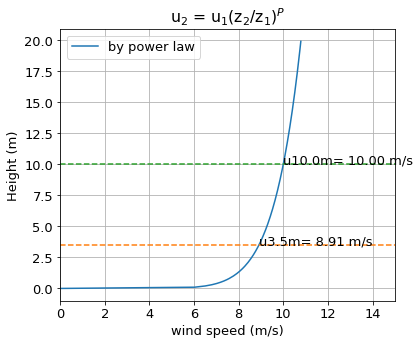

In [147]:
''' test plot power law derived wind profile '''
z_profile = np.arange(0,20,0.1) # m
u1 = 10
z1 = 10
u_profile = wind_adj2height_PL(u1, z1, z_profile)
plt.clf()
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(6,5))
plt.plot(u_profile, z_profile,label='by power law')
z_pick = [3.5,10]
for i, z in enumerate( z_pick ):
    plt.plot([z_profile[0],z_profile[-1]],[z,z],'--',label='')
    id = np.where( z_profile == z )[0][0]
    plt.text(u_profile[id], z_profile[id],'u{:.1f}m= {:.2f} m/s'.format(z, u_profile[id]))
# plt.plot([z_profile[0],z_profile[-1]],[10,10],'--',label='10 m')
plt.grid()
plt.legend()
plt.ylabel('Height (m)')
plt.xlabel('wind speed (m/s)')
plt.xlim([0,15])
plt.title('u$_2$ = u$_1$(z$_2$/z$_1$)$^P$')
''' save figure '''
plt.savefig('wind_profile_power-law.png',dpi=400,bbox_inches='tight')